In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU Count: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i}: {torch.cuda.get_device_name(i)}')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

data_path = '/kaggle/input/plant-village-dataset-updated'

# Target crops we want to train on
# target_crops = ['Apple', 'Tomato', 'Corn_(maize)']
target_crops = [
    'Apple',
    'Bell Pepper',
    'Cherry',
    'Corn (Maize)',
    'Grape',
    'Peach',
    'Potato',
    'Strawberry',
    'Tomato'
]



print(f"Target crops: {target_crops}")

#explore the dataset structure
if os.path.exists(data_path):
    all_folders = os.listdir(data_path)
    crop_folders = [folder for folder in all_folders if any(crop.lower() in folder.lower() for crop in ['Apple',
    'Bell Pepper',
    'Cherry',
    'Corn (Maize)',
    'Grape',
    'Peach',
    'Potato',
    'Strawberry',
    'Tomato'])]
    print(f"\nFound crop folders: {crop_folders}")
else:
    print(f"Data path {data_path} not found. Please check the path.")

Using device: cuda
GPU Count: 1
GPU 0: Tesla P100-PCIE-16GB
Target crops: ['Apple', 'Bell Pepper', 'Cherry', 'Corn (Maize)', 'Grape', 'Peach', 'Potato', 'Strawberry', 'Tomato']

Found crop folders: ['Tomato', 'Apple', 'Bell Pepper', 'Strawberry', 'Corn (Maize)', 'Peach', 'Grape', 'Cherry', 'Potato']


In [6]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_crops=None, split='Train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.data = []
        self.classes = []
        self.class_to_idx = {}
        
        # Normalize crop names for flexible matching
        normalized_targets = [c.lower().replace('_', '').replace('(', '').replace(')', '').replace(' ', '') 
                             for c in target_crops]
        
        # Collect all unique plant_disease  across crops
        all_classes = set()
        actual_crop_folders = {}  # Map normalized name to actual folder name
        
        # First pass: find matching crop folders
        for folder in os.listdir(root_dir):
            full_path = os.path.join(root_dir, folder)
            if os.path.isdir(full_path):
                normalized = folder.lower().replace('_', '').replace('(', '').replace(')', '').replace(' ', '')
                for i, norm_target in enumerate(normalized_targets):
                    if norm_target == normalized:
                        actual_crop_folders[target_crops[i]] = folder
                        break
        
        print(f"Matched crop folders: {actual_crop_folders}")
        
        # Second pass: process matched crops
        for crop_key, actual_folder in actual_crop_folders.items():
            split_dir = os.path.join(root_dir, actual_folder, split)
            if not os.path.exists(split_dir):
                print(f"Warning: {split} directory not found for {actual_folder}")
                continue
                
            disease_folders = [d for d in os.listdir(split_dir) 
                              if os.path.isdir(os.path.join(split_dir, d))]
            for disease in disease_folders:
                class_name = f"{crop_key}_{disease.replace(' ', '_')}"
                all_classes.add(class_name)
        
        # Sort classes and create index mapping
        self.classes = sorted(list(all_classes))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        print(f"Found {len(self.classes)} classes:")
        for idx, cls in enumerate(self.classes):
            print(f"  {idx}: {cls}")
        
        # Load images with combined labels
        for crop_key, actual_folder in actual_crop_folders.items():
            split_dir = os.path.join(root_dir, actual_folder, split)
            if not os.path.exists(split_dir):
                continue
                
            disease_folders = [d for d in os.listdir(split_dir) 
                              if os.path.isdir(os.path.join(split_dir, d))]
            for disease in disease_folders:
                class_name = f"{crop_key}_{disease.replace(' ', '_')}"
                class_idx = self.class_to_idx[class_name]
                disease_dir = os.path.join(split_dir, disease)
                image_count = 0
                
                for root, _, files in os.walk(disease_dir):
                    for file in files:
                        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(root, file)
                            self.data.append((img_path, class_idx))
                            image_count += 1
                print(f"  {class_name}: {image_count} images")
        
        print(f"\nTotal images: {len(self.data)}")
    
    # Keep __len__ and __getitem__ the same

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            print(f"Warning: Failed to load image {img_path}")

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
# Define transforms with advanced augmentation techniques
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
print("Creating dataset...")
full_dataset = PlantDiseaseDataset(data_path, transform=None, target_crops=target_crops)

# Split dataset into train/val/test (80/10/10)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size  # Remainder for test

print(f"\nDataset split:")
print(f"  Training: {train_size} images")
print(f"  Validation: {val_size} images")
print(f"  Test: {test_size} images")

# Create train, validation, and test indices
indices = torch.randperm(dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]



Creating dataset...
Matched crop folders: {'Tomato': 'Tomato', 'Apple': 'Apple', 'Bell Pepper': 'Bell Pepper', 'Strawberry': 'Strawberry', 'Corn (Maize)': 'Corn (Maize)', 'Peach': 'Peach', 'Grape': 'Grape', 'Cherry': 'Cherry', 'Potato': 'Potato'}
Found 29 classes:
  0: Apple_Apple_Scab
  1: Apple_Black_Rot
  2: Apple_Cedar_Apple_Rust
  3: Apple_Healthy
  4: Bell Pepper_Bacterial_Spot
  5: Bell Pepper_Healthy
  6: Cherry_Healthy
  7: Cherry_Powdery_Mildew
  8: Corn (Maize)_Cercospora_Leaf_Spot
  9: Corn (Maize)_Common_Rust_
  10: Corn (Maize)_Healthy
  11: Corn (Maize)_Northern_Leaf_Blight
  12: Grape_Black_Rot
  13: Grape_Esca_(Black_Measles)
  14: Grape_Healthy
  15: Grape_Leaf_Blight
  16: Peach_Bacterial_Spot
  17: Peach_Healthy
  18: Potato_Early_Blight
  19: Potato_Healthy
  20: Potato_Late_Blight
  21: Strawberry_Healthy
  22: Strawberry_Leaf_Scorch
  23: Tomato_Bacterial_Spot
  24: Tomato_Early_Blight
  25: Tomato_Healthy
  26: Tomato_Late_Blight
  27: Tomato_Septoria_Leaf_Spot


In [8]:
class IndexedDataset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img_path, label = self.base_dataset.data[original_idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [9]:
target_crops = ['Apple',
    'Bell Pepper',
    'Cherry',
    'Corn (Maize)',
    'Grape',
    'Peach',
    'Potato',
    'Strawberry',
    'Tomato']
train_dataset = PlantDiseaseDataset(
    data_path, 
    transform=train_transforms, 
    target_crops=target_crops, 
    split='Train'
)

val_dataset = PlantDiseaseDataset(
    data_path, 
    transform=val_transforms, 
    target_crops=target_crops, 
    split='Val'
)

test_dataset = PlantDiseaseDataset(
    data_path, 
    transform=val_transforms,  
    target_crops=target_crops, 
    split='Test' 
)


batch_size = 128  
num_workers = 6  

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory = True)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

print(f"  test batches: {len(test_loader)}")
print(f"  Batch size: {batch_size}")

Matched crop folders: {'Tomato': 'Tomato', 'Apple': 'Apple', 'Bell Pepper': 'Bell Pepper', 'Strawberry': 'Strawberry', 'Corn (Maize)': 'Corn (Maize)', 'Peach': 'Peach', 'Grape': 'Grape', 'Cherry': 'Cherry', 'Potato': 'Potato'}
Found 29 classes:
  0: Apple_Apple_Scab
  1: Apple_Black_Rot
  2: Apple_Cedar_Apple_Rust
  3: Apple_Healthy
  4: Bell Pepper_Bacterial_Spot
  5: Bell Pepper_Healthy
  6: Cherry_Healthy
  7: Cherry_Powdery_Mildew
  8: Corn (Maize)_Cercospora_Leaf_Spot
  9: Corn (Maize)_Common_Rust_
  10: Corn (Maize)_Healthy
  11: Corn (Maize)_Northern_Leaf_Blight
  12: Grape_Black_Rot
  13: Grape_Esca_(Black_Measles)
  14: Grape_Healthy
  15: Grape_Leaf_Blight
  16: Peach_Bacterial_Spot
  17: Peach_Healthy
  18: Potato_Early_Blight
  19: Potato_Healthy
  20: Potato_Late_Blight
  21: Strawberry_Healthy
  22: Strawberry_Leaf_Scorch
  23: Tomato_Bacterial_Spot
  24: Tomato_Early_Blight
  25: Tomato_Healthy
  26: Tomato_Late_Blight
  27: Tomato_Septoria_Leaf_Spot
  28: Tomato_Yellow_

In [10]:
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(PlantDiseaseClassifier, self).__init__()
        
        # Use EfficientNet as backbone for better performance
        self.backbone = models.efficientnet_b2(pretrained=True)
        
        # Freeze early layers to prevent overfitting
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # Get feature dimension
        num_features = self.backbone.classifier[1].in_features
        
        # Replace classifier with custom head
        self.backbone.classifier = nn.Identity()
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(num_features, num_features // 4),
            nn.ReLU(),
            nn.Linear(num_features // 4, num_features),
            nn.Sigmoid()
        )
        
        # Custom classifier head with regularization
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Extract features
        features = self.backbone.features(x)
        
        # Global average pooling
        pooled = F.adaptive_avg_pool2d(features, 1)
        pooled = torch.flatten(pooled, 1)
        
        # Apply attention
        attention_weights = self.attention(features)
        attended_features = pooled * attention_weights
        
        # Classification
        output = self.classifier(attended_features)
        
        return output

# Create model
num_classes = len(full_dataset.classes)
model = PlantDiseaseClassifier(num_classes=num_classes)

# Setup for multi-GPU training
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

print(f"Model created with {num_classes} classes")
print("Model architecture setup complete!")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 178MB/s]


Model created with 29 classes
Model architecture setup complete!


In [12]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        log_prob = F.log_softmax(pred, dim=-1)
        weight = pred.new_ones(pred.size()) * self.smoothing / (pred.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

# Loss function and optimizer with advanced techniques
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# AdamW optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=0.01,
    eps=1e-8
)

# Cosine annealing scheduler with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10, 
    T_mult=2, 
    eta_min=1e-6
)

# Early stopping and model checkpoint
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopping = EarlyStopping(patience=10, min_delta=0.001)


In [13]:

from tqdm.notebook import tqdm



def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for data, target in progress_bar:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{100. * correct / total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    progress_bar = tqdm(val_loader, desc='Validating', leave=False)
    with torch.no_grad():
        for data, target in progress_bar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{100. * correct / total:.2f}%')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_targets



# Training history tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"Optimizer: AdamW with weight decay")
print(f"Scheduler: CosineAnnealingWarmRestarts")
print(f"Loss: Label Smoothing Cross Entropy")
print(f"Early stopping patience: {early_stopping.patience}")
print("Ready to start training!")

Optimizer: AdamW with weight decay
Scheduler: CosineAnnealingWarmRestarts
Loss: Label Smoothing Cross Entropy
Early stopping patience: 10
Ready to start training!


In [14]:
num_epochs = 15
best_val_acc = 0.0

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 40)
    
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase
    val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {current_lr:.2e}')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': full_dataset.classes
        }, 'best_plant_model.pth')
        print(f'New best model saved! Val Acc: {val_acc:.2f}%')
    
    # Early stopping check
    if early_stopping(val_loss, model):
        print(f'Early stopping triggered at epoch {epoch+1}')
        model.load_state_dict(early_stopping.best_model)
        break
    
    # Memory cleanup
    torch.cuda.empty_cache()
    
    print(f'GPU Memory Used: {torch.cuda.memory_allocated()/1024**3:.2f} GB')

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Starting training...

Epoch 1/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 1.3278, Train Acc: 83.31%
Val Loss: 0.8598, Val Acc: 97.00%
Learning Rate: 9.82e-04
New best model saved! Val Acc: 97.00%
GPU Memory Used: 0.10 GB

Epoch 2/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.8959, Train Acc: 94.35%
Val Loss: 0.7776, Val Acc: 98.03%
Learning Rate: 9.85e-04
New best model saved! Val Acc: 98.03%
GPU Memory Used: 0.10 GB

Epoch 3/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.8296, Train Acc: 95.67%
Val Loss: 0.7409, Val Acc: 98.47%
Learning Rate: 9.87e-04
New best model saved! Val Acc: 98.47%
GPU Memory Used: 0.10 GB

Epoch 4/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.8013, Train Acc: 96.33%
Val Loss: 0.7407, Val Acc: 98.55%
Learning Rate: 9.87e-04
New best model saved! Val Acc: 98.55%
GPU Memory Used: 0.10 GB

Epoch 5/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7728, Train Acc: 96.99%
Val Loss: 0.7175, Val Acc: 98.48%
Learning Rate: 9.87e-04
GPU Memory Used: 0.10 GB

Epoch 6/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7579, Train Acc: 97.40%
Val Loss: 0.7037, Val Acc: 98.71%
Learning Rate: 9.88e-04
New best model saved! Val Acc: 98.71%
GPU Memory Used: 0.10 GB

Epoch 7/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7479, Train Acc: 97.55%
Val Loss: 0.6982, Val Acc: 98.97%
Learning Rate: 9.88e-04
New best model saved! Val Acc: 98.97%
GPU Memory Used: 0.10 GB

Epoch 8/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7410, Train Acc: 97.70%
Val Loss: 0.6898, Val Acc: 99.01%
Learning Rate: 9.88e-04
New best model saved! Val Acc: 99.01%
GPU Memory Used: 0.10 GB

Epoch 9/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7344, Train Acc: 97.85%
Val Loss: 0.6868, Val Acc: 99.10%
Learning Rate: 9.88e-04
New best model saved! Val Acc: 99.10%
GPU Memory Used: 0.10 GB

Epoch 10/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7297, Train Acc: 97.95%
Val Loss: 0.6845, Val Acc: 99.11%
Learning Rate: 9.88e-04
New best model saved! Val Acc: 99.11%
GPU Memory Used: 0.10 GB

Epoch 11/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7254, Train Acc: 98.11%
Val Loss: 0.6856, Val Acc: 99.18%
Learning Rate: 9.88e-04
New best model saved! Val Acc: 99.18%
GPU Memory Used: 0.10 GB

Epoch 12/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7217, Train Acc: 98.07%
Val Loss: 0.6823, Val Acc: 99.21%
Learning Rate: 9.89e-04
New best model saved! Val Acc: 99.21%
GPU Memory Used: 0.10 GB

Epoch 13/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7175, Train Acc: 98.19%
Val Loss: 0.6796, Val Acc: 99.25%
Learning Rate: 9.89e-04
New best model saved! Val Acc: 99.25%
GPU Memory Used: 0.10 GB

Epoch 14/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7139, Train Acc: 98.43%
Val Loss: 0.6824, Val Acc: 99.06%
Learning Rate: 9.89e-04
GPU Memory Used: 0.10 GB

Epoch 15/15
----------------------------------------


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7104, Train Acc: 98.47%
Val Loss: 0.6777, Val Acc: 99.30%
Learning Rate: 9.89e-04
New best model saved! Val Acc: 99.30%
GPU Memory Used: 0.10 GB

Training completed!
Best validation accuracy: 99.30%


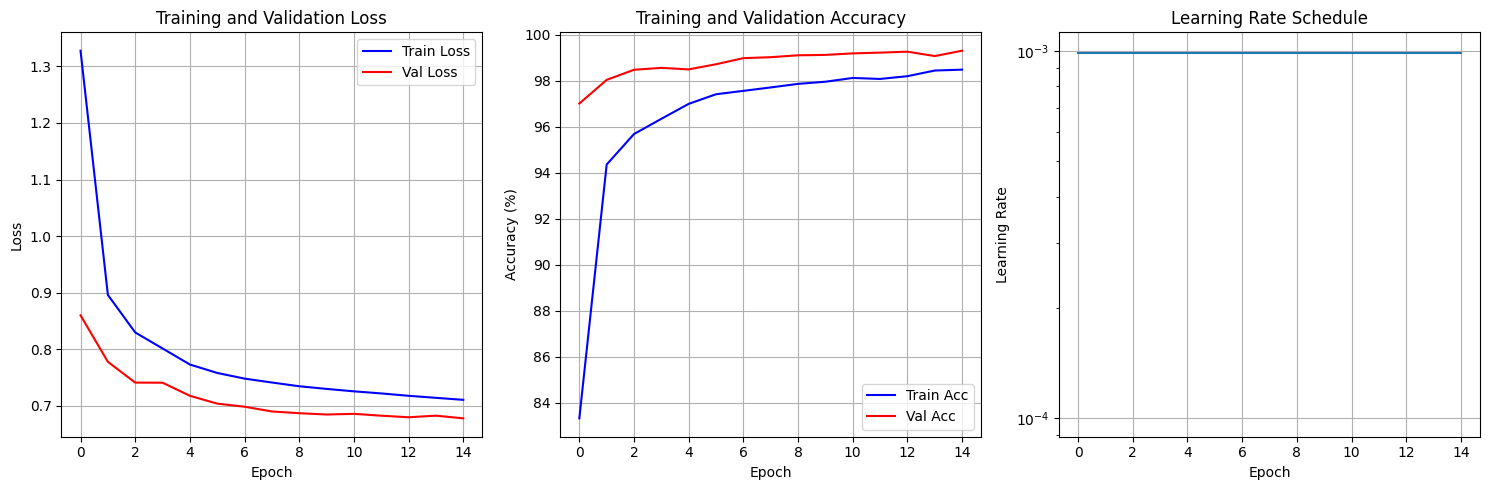

Training visualization complete!


In [39]:

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Acc', color='blue')
plt.plot(val_accuracies, label='Val Acc', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot([optimizer.param_groups[0]['lr'] for _ in range(len(train_losses))])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training visualization complete!")


Evaluating on test set...


Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Test Loss: 0.6826, Test Acc: 99.12%

Classification Report for Test Set:
                                   precision    recall  f1-score   support

                 Apple_Apple_Scab       1.00      0.98      0.99        51
                  Apple_Black_Rot       1.00      1.00      1.00        50
           Apple_Cedar_Apple_Rust       1.00      1.00      1.00        44
                    Apple_Healthy       1.00      1.00      1.00        51
       Bell Pepper_Bacterial_Spot       1.00      1.00      1.00        48
              Bell Pepper_Healthy       1.00      1.00      1.00        50
                   Cherry_Healthy       1.00      1.00      1.00        46
            Cherry_Powdery_Mildew       1.00      1.00      1.00        43
Corn (Maize)_Cercospora_Leaf_Spot       0.95      0.91      0.93        45
        Corn (Maize)_Common_Rust_       0.98      1.00      0.99        48
             Corn (Maize)_Healthy       1.00      1.00      1.00        47
Corn (Maize)_Northern_Leaf

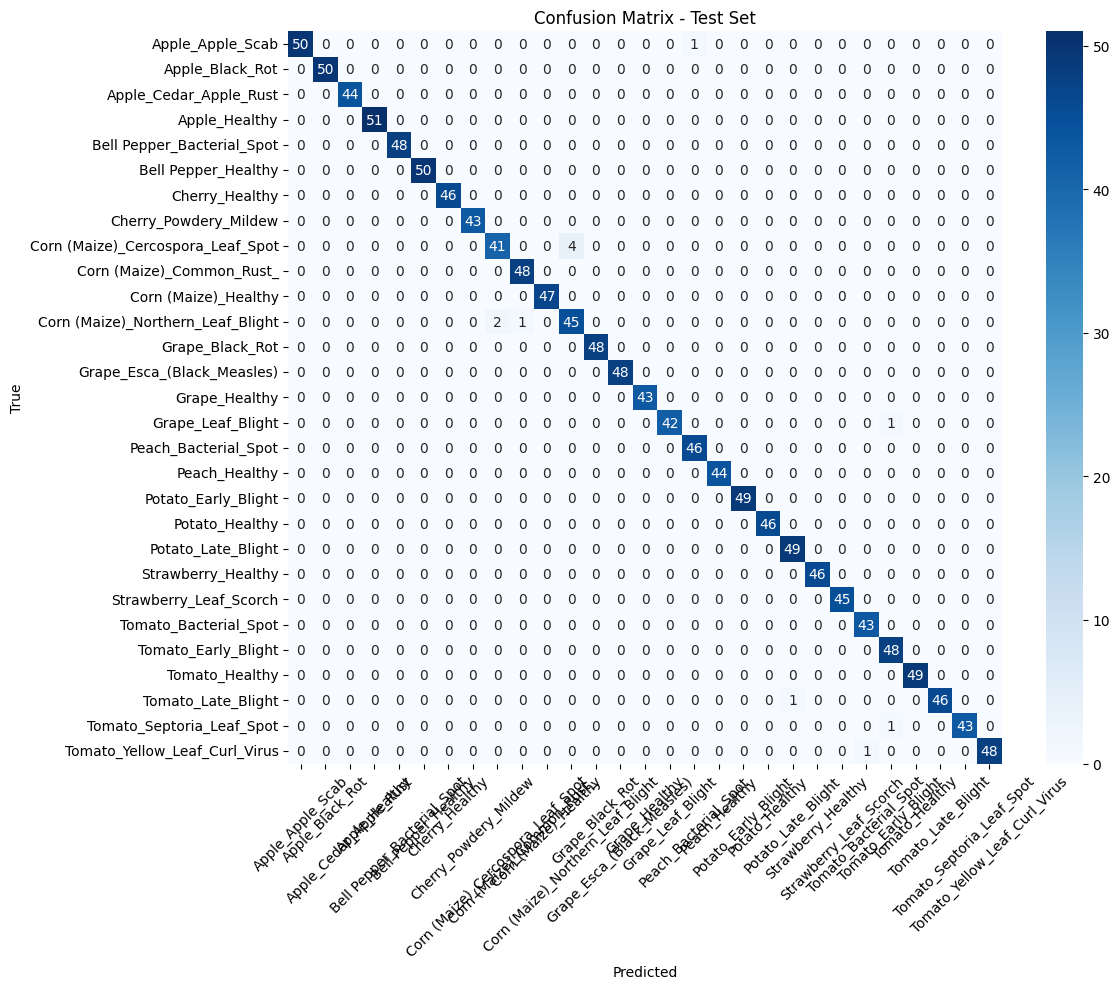


Test evaluation complete!


In [40]:
# After training completes, evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_preds, test_targets = validate_epoch(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Classification report and confusion matrix for test set
print("\nClassification Report for Test Set:")
print(classification_report(test_targets, test_preds, target_names=full_dataset.classes))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.classes, 
            yticklabels=full_dataset.classes)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('test_confusion_matrix.png')
plt.show()

print("\nTest evaluation complete!")

Loaded best model from epoch 15
Best validation accuracy: 99.30%


Validating:   0%|          | 0/95 [00:00<?, ?it/s]


Final evaluation results:
Validation Loss: 0.6777
Validation Accuracy: 99.30%

Detailed Classification Report:
                                   precision    recall  f1-score   support

                 Apple_Apple_Scab     1.0000    0.9956    0.9978       453
                  Apple_Black_Rot     0.9955    1.0000    0.9978       447
           Apple_Cedar_Apple_Rust     1.0000    0.9899    0.9949       396
                    Apple_Healthy     0.9956    1.0000    0.9978       451
       Bell Pepper_Bacterial_Spot     1.0000    0.9977    0.9988       430
              Bell Pepper_Healthy     0.9781    0.9978    0.9878       447
                   Cherry_Healthy     1.0000    0.9976    0.9988       410
            Cherry_Powdery_Mildew     0.9973    0.9947    0.9960       378
Corn (Maize)_Cercospora_Leaf_Spot     0.9638    0.9377    0.9505       369
        Corn (Maize)_Common_Rust_     1.0000    0.9977    0.9988       429
             Corn (Maize)_Healthy     1.0000    1.0000    1.00

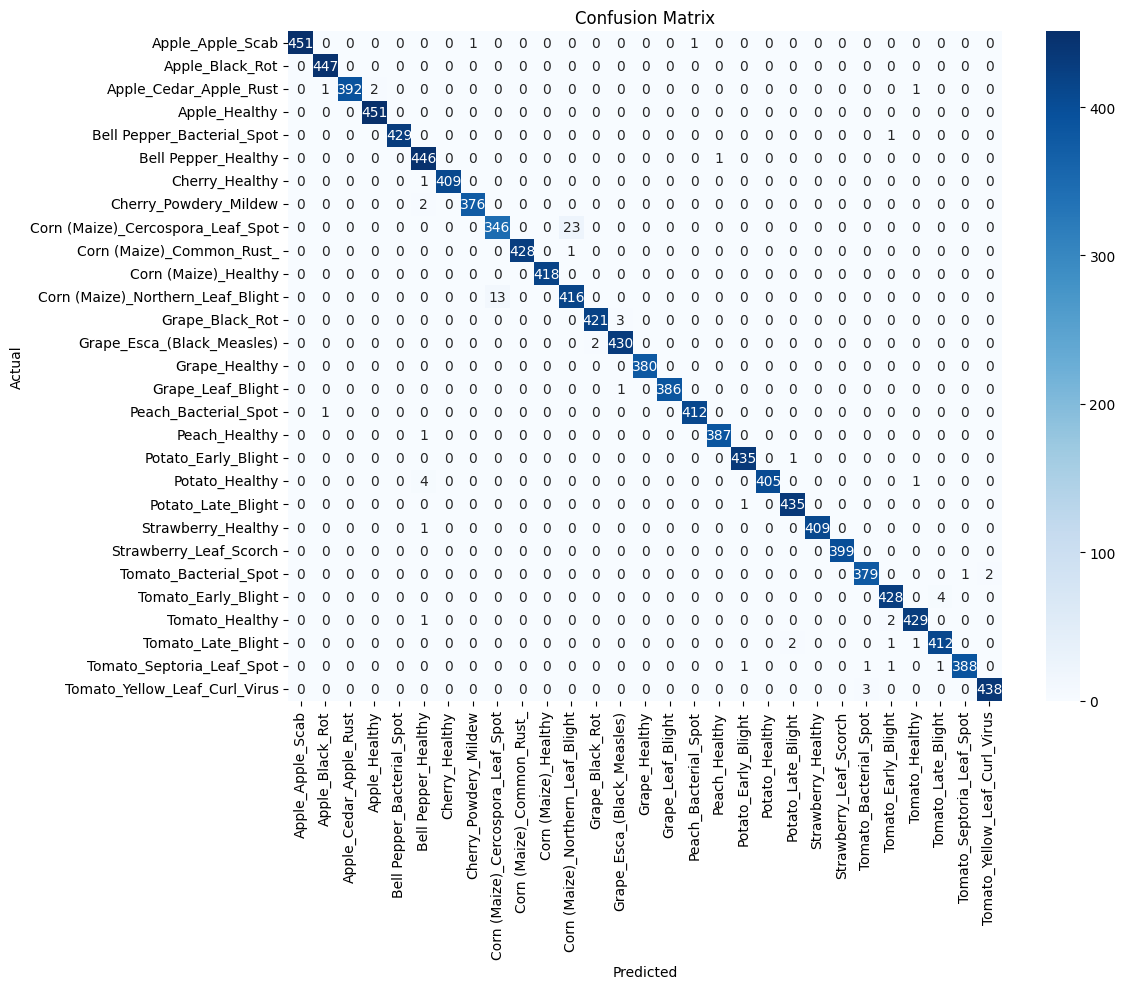

Apple_Apple_Scab: 99.56%
Apple_Black_Rot: 100.00%
Apple_Cedar_Apple_Rust: 98.99%
Apple_Healthy: 100.00%
Bell Pepper_Bacterial_Spot: 99.77%
Bell Pepper_Healthy: 99.78%
Cherry_Healthy: 99.76%
Cherry_Powdery_Mildew: 99.47%
Corn (Maize)_Cercospora_Leaf_Spot: 93.77%
Corn (Maize)_Common_Rust_: 99.77%
Corn (Maize)_Healthy: 100.00%
Corn (Maize)_Northern_Leaf_Blight: 96.97%
Grape_Black_Rot: 99.29%
Grape_Esca_(Black_Measles): 99.54%
Grape_Healthy: 100.00%
Grape_Leaf_Blight: 99.74%
Peach_Bacterial_Spot: 99.76%
Peach_Healthy: 99.74%
Potato_Early_Blight: 99.77%
Potato_Healthy: 98.78%
Potato_Late_Blight: 99.77%
Strawberry_Healthy: 99.76%
Strawberry_Leaf_Scorch: 100.00%
Tomato_Bacterial_Spot: 99.21%
Tomato_Early_Blight: 99.07%
Tomato_Healthy: 99.31%
Tomato_Late_Blight: 99.04%
Tomato_Septoria_Leaf_Spot: 98.98%
Tomato_Yellow_Leaf_Curl_Virus: 99.32%


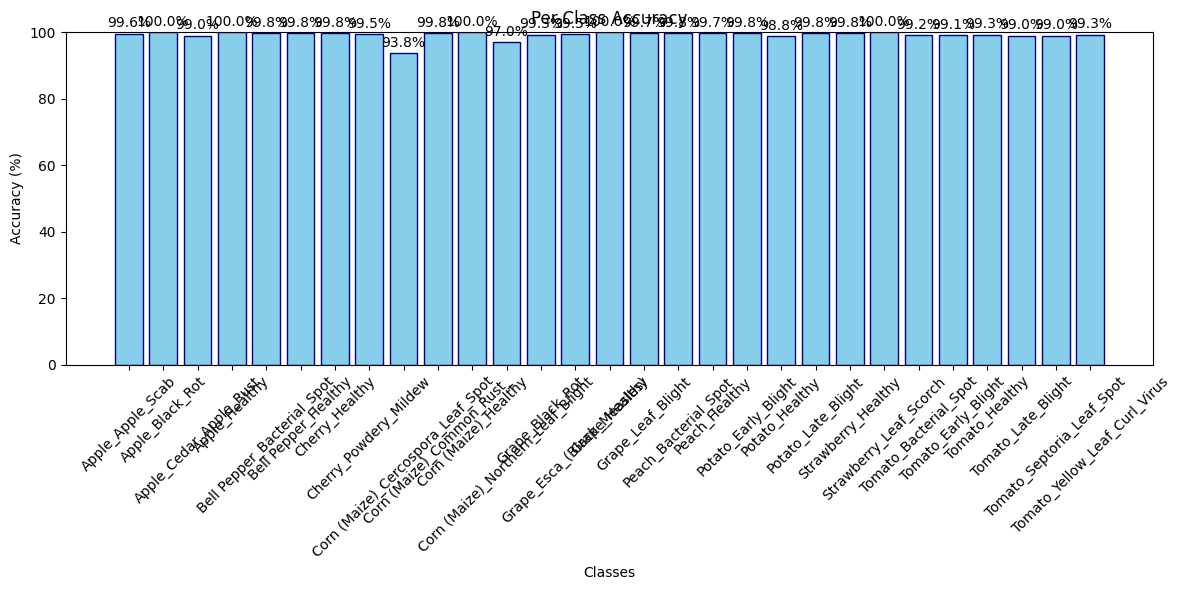

Model evaluation complete!


In [41]:
# Load the best model for evaluation
checkpoint = torch.load('best_plant_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Final evaluation on validation set
final_val_loss, final_val_acc, final_preds, final_targets = validate_epoch(
    model, val_loader, criterion, device
)

print(f"\nFinal evaluation results:")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.2f}%")

# Detailed classification report
class_names = full_dataset.classes
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(final_targets, final_preds, target_names=class_names, digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(final_targets, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy analysis
class_accuracies = []
for i in range(len(class_names)):
    class_mask = np.array(final_targets) == i
    if class_mask.sum() > 0:
        class_acc = (np.array(final_preds)[class_mask] == i).mean() * 100
        class_accuracies.append(class_acc)
        print(f"{class_names[i]}: {class_acc:.2f}%")
    else:
        class_accuracies.append(0)

# Visualize per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(class_names)), class_accuracies, color='skyblue', edgecolor='navy')
plt.title('Per-Class Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Model evaluation complete!")


In [42]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)
print(f"\nModel Complexity:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Model size
model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
print(f"Model size: {model_size:.2f} MB")


Model Complexity:
Total parameters: 9,555,711
Trainable parameters: 4,242,773
Non-trainable parameters: 5,312,938
Model size: 36.45 MB


Testing model on sample images...


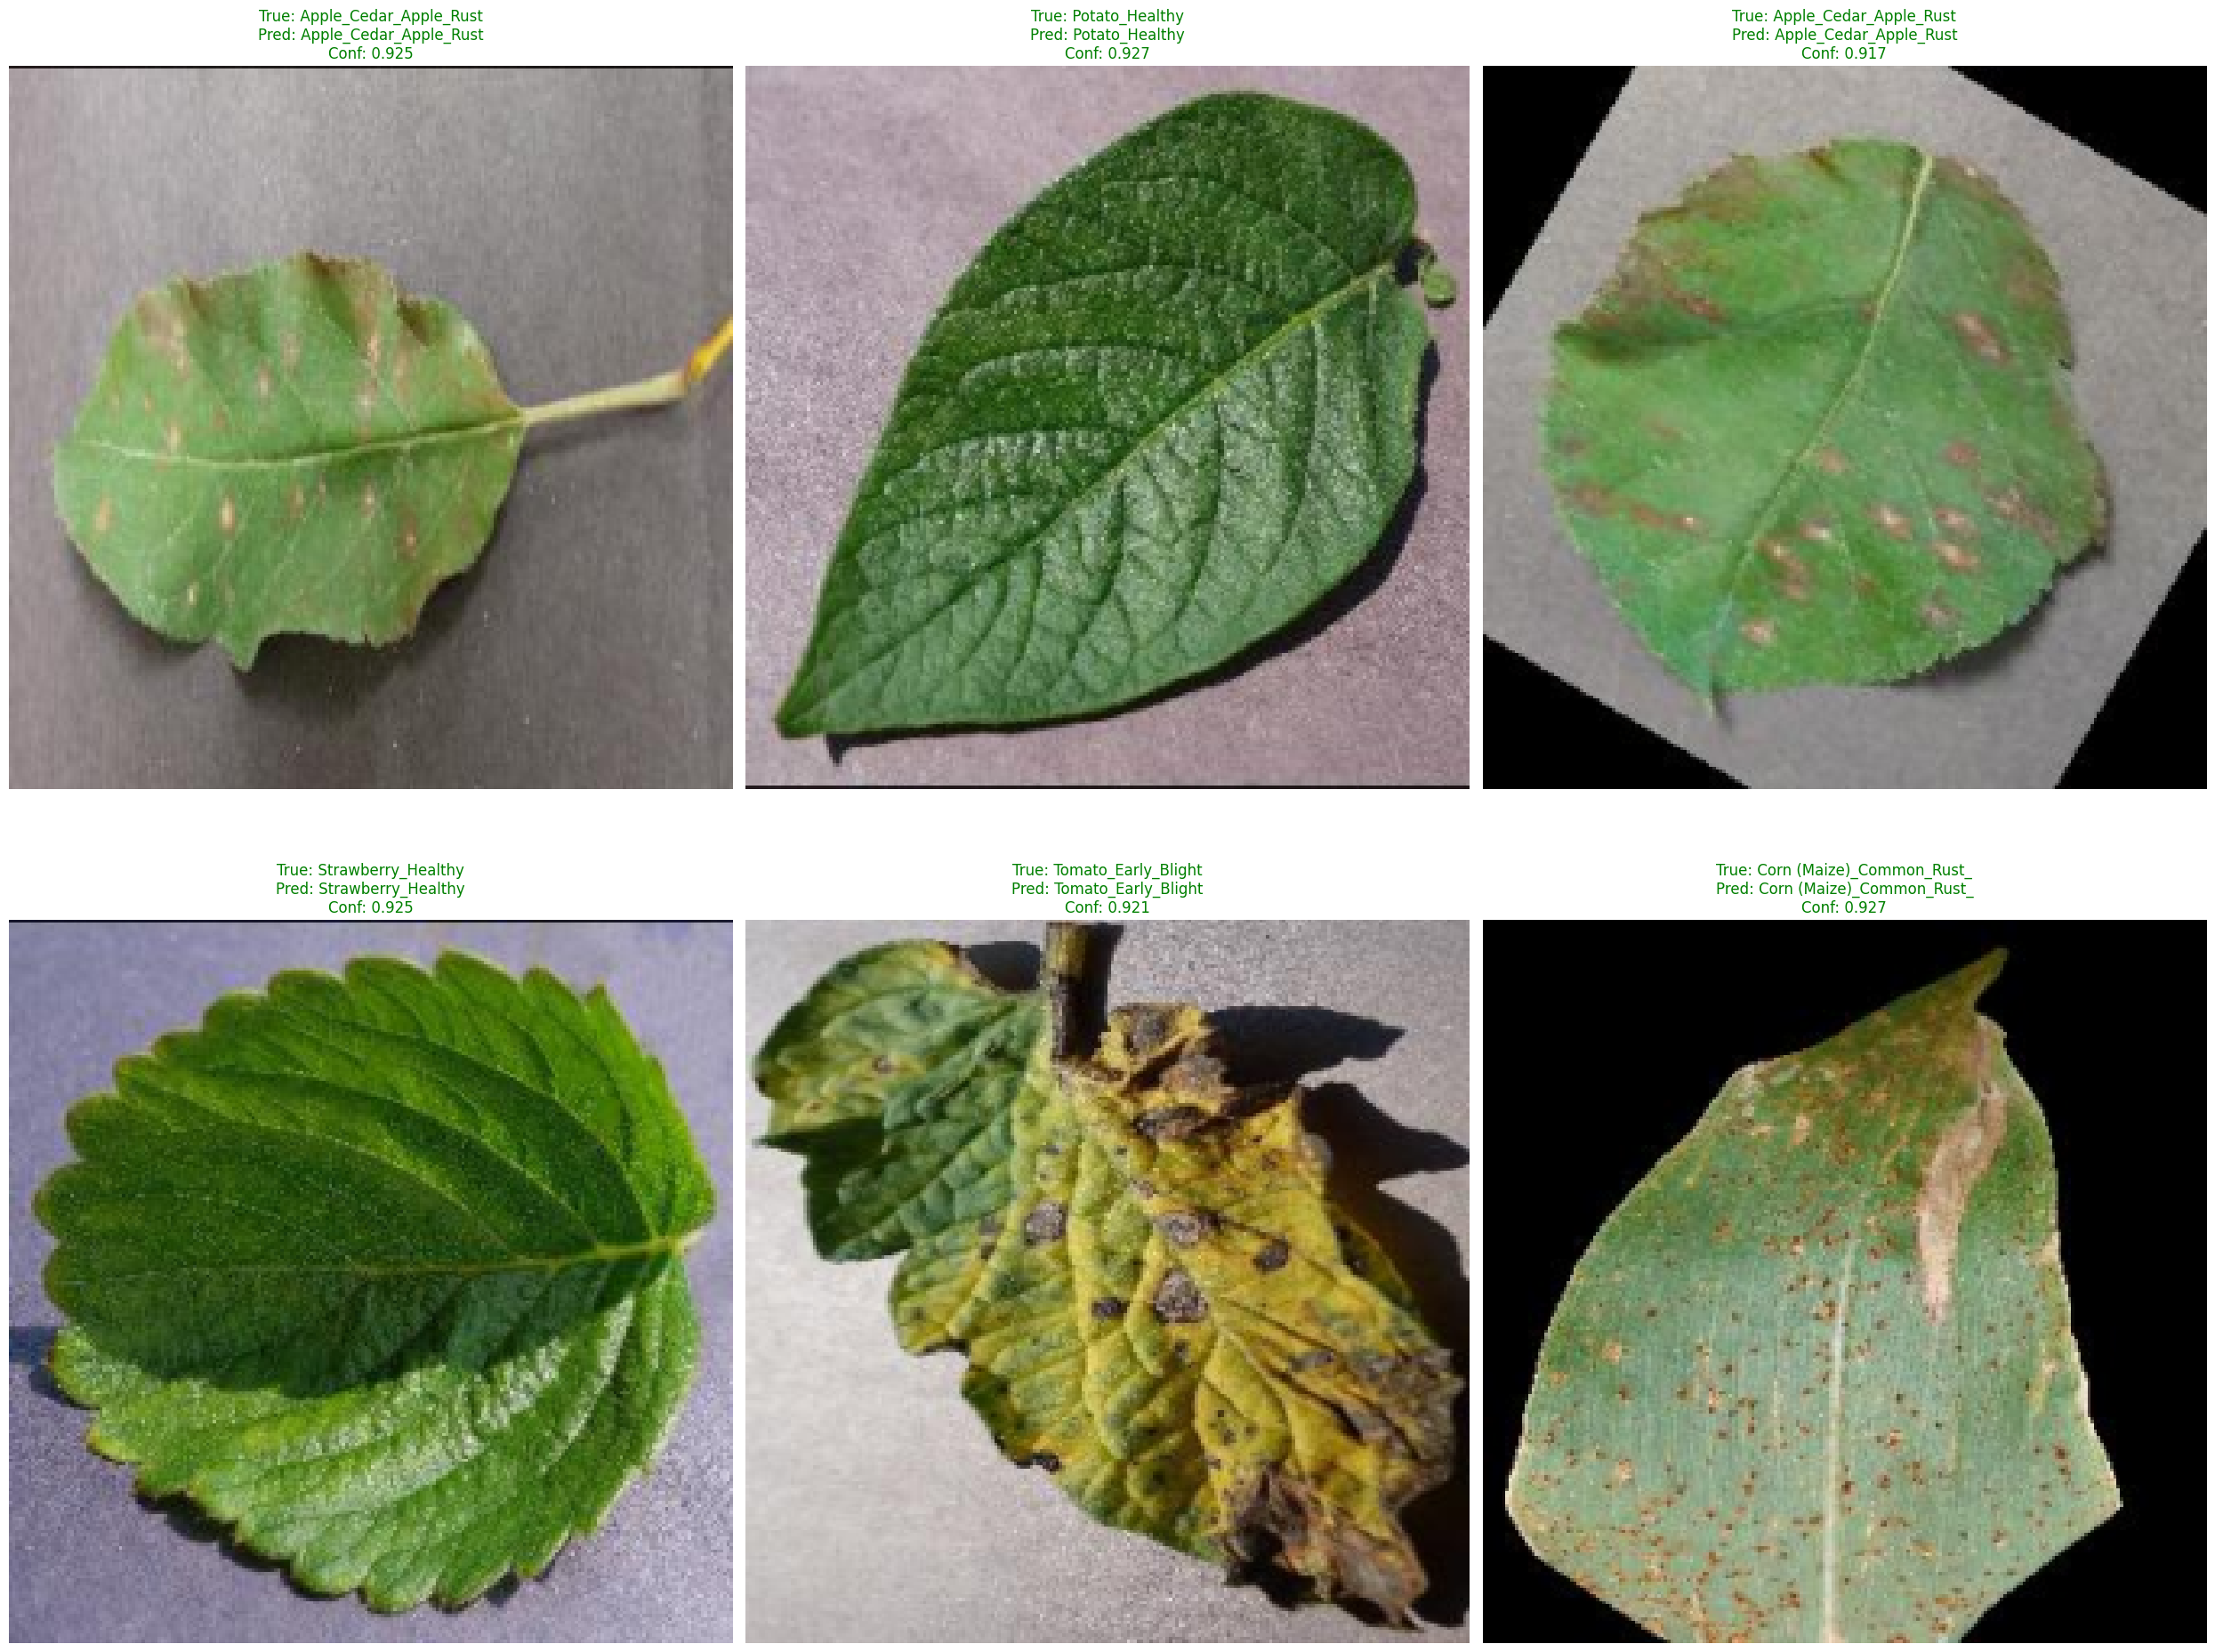

In [43]:
def predict_image(model, image_path, transform, class_names, device):
    """
    Predict the class of a single image
    """
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item()
    
    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]

# Test the model on some sample images from validation set
def test_sample_predictions(model, val_dataset, class_names, device, num_samples=6):
    """
    Test model on random samples and visualize predictions
    """
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)
    
    plt.figure(figsize=(25, 20))
    
    for i, idx in enumerate(indices):
        image, true_label = val_dataset[idx]
        
        # Get prediction
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        true_class = class_names[true_label]
        confidence_score = confidence.item()
        
        # Convert tensor to displayable image
        img_display = image.cpu().clone()
        img_display = img_display * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_display = torch.clamp(img_display, 0, 1)
        img_display = img_display.permute(1, 2, 0)
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_display)
        plt.title(f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence_score:.3f}')
        plt.axis('off')
        
        # Color code the title based on correctness
        if predicted_class == true_class:
            plt.gca().title.set_color('green')
        else:
            plt.gca().title.set_color('red')
    
    plt.tight_layout()
    plt.show()

# Test sample predictions
print("Testing model on sample images...")
test_sample_predictions(model, val_dataset, class_names, device)

# Create a comprehensive prediction function
def analyze_prediction(model, image_path, transform, class_names, device, top_k=3):
    """
    Detailed analysis of prediction with top-k results
    """
    predicted_class, confidence, probabilities = predict_image(
        model, image_path, transform, class_names, device
    )
    
    # Get top-k predictions
    top_k_indices = np.argsort(probabilities)[-top_k:][::-1]
    
    print(f"Image: {image_path}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    print(f"\nTop-{top_k} Predictions:")
    print("-" * 40)
    
    for i, idx in enumerate(top_k_indices):
        print(f"{i+1}. {class_names[idx]}: {probabilities[idx]:.4f}")
    
    return predicted_class, confidence, probabilities





In [44]:
# Save the final model 
def save_complete_model(model, class_names, save_path='plant_disease_classifier.pth'):
    """
    Save complete model with metadata
    """
    
    if hasattr(model, 'module'):  # If using DataParallel
        model_state = model.module.state_dict()
    else:
        model_state = model.state_dict()
    
    torch.save({
        'model_state_dict': model_state,
        'class_names': class_names,
        'num_classes': len(class_names),
        'model_architecture': 'PlantDiseaseClassifier',
        'input_size': (224, 224),
        'normalization_mean': [0.485, 0.456, 0.406],
        'normalization_std': [0.229, 0.224, 0.225],
        'training_info': {
            'best_val_acc': best_val_acc,
            'total_epochs': len(train_losses),
            'optimizer': 'AdamW',
            'scheduler': 'CosineAnnealingWarmRestarts',
            'loss_function': 'LabelSmoothingCrossEntropy'
        }
    }, save_path)
    
    print(f"Complete model saved to {save_path}")

# Save the complete model
save_complete_model(model, class_names)



Complete model saved to plant_disease_classifier.pth


In [45]:
# Performance summary
print("TRAINING SUMMARY")
print(f"Dataset: Plant Village (Apple, Tomato, Corn)")
print(f"Total Classes: {len(class_names)}")
print(f"Training Images: {train_size}")
print(f"Validation Images: {val_size}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Total Training Epochs: {len(train_losses)}")
print(f"Model Parameters: {trainable_params:,} trainable")
print(f"Model Size: {model_size:.2f} MB")
print("\nAdvanced Techniques Used:")
print("- EfficientNet-B2 backbone with transfer learning")
print("- Attention mechanism")
print("- Label smoothing cross-entropy loss")
print("- Advanced data augmentation")
print("- AdamW optimizer with weight decay")
print("- Cosine annealing with warm restarts")
print("- Early stopping")
print("- Gradient clipping")
print("- Batch normalization and dropout")
print("- Multi-GPU training support")


TRAINING SUMMARY
Dataset: Plant Village (Apple, Tomato, Corn)
Total Classes: 29
Training Images: 42954
Validation Images: 5369
Best Validation Accuracy: 99.30%
Total Training Epochs: 15
Model Parameters: 4,242,773 trainable
Model Size: 36.45 MB

Advanced Techniques Used:
- EfficientNet-B2 backbone with transfer learning
- Attention mechanism
- Label smoothing cross-entropy loss
- Advanced data augmentation
- AdamW optimizer with weight decay
- Cosine annealing with warm restarts
- Early stopping
- Gradient clipping
- Batch normalization and dropout
- Multi-GPU training support


Model loaded successfully!
Device: cuda
Classes: 29

Demo: How to use the predictor
----------------------------------------
True class: Grape_Leaf_Blight

Predictions:
1. Grape_Leaf_Blight: 90.07%
2. Tomato_Late_Blight: 0.90%
3. Grape_Esca_(Black_Measles): 0.86%


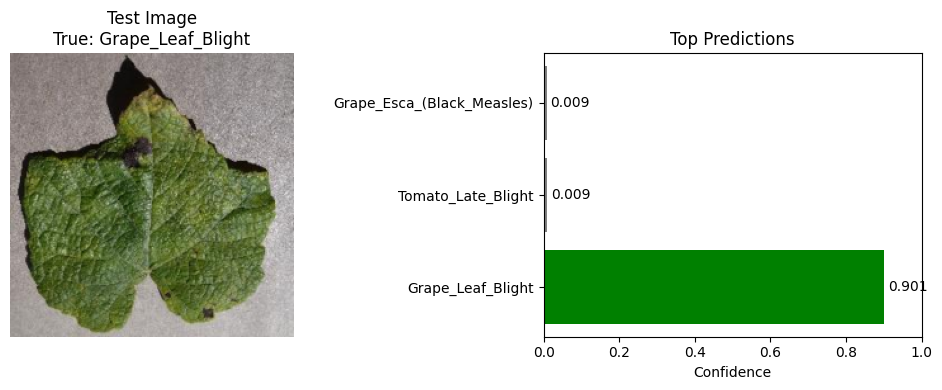


Exporting model...
✓ TorchScript model saved: plant_disease_model_scripted.pt
✓ Model info saved: model_info.txt

🎉 Training pipeline completed successfully!

Files created:
- best_plant_model.pth (training checkpoint)
- plant_disease_classifier.pth (production model)
- plant_disease_model_scripted.pt (TorchScript)
- model_info.txt (model documentation)

Your model is ready for deployment! 🚀


In [46]:
class PlantDiseasePredictor:
    def __init__(self, model_path, device=None):
        """
        Initialize the predictor with a saved model
        """
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        
        # Load model checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Extract model info
        self.class_names = checkpoint['class_names']
        self.num_classes = len(self.class_names)
        
        # Recreate model architecture
        self.model = PlantDiseaseClassifier(num_classes=self.num_classes)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        # Setup transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print(f"Model loaded successfully!")
        print(f"Device: {self.device}")
        print(f"Classes: {len(self.class_names)}")
    
    def predict(self, image_path, top_k=3):
        """
        Predict disease from image path
        """
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]
        
        # Get top-k predictions
        top_indices = np.argsort(probabilities)[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            results.append({
                'class': self.class_names[idx],
                'confidence': float(probabilities[idx]),
                'percentage': f"{probabilities[idx]*100:.2f}%"
            })
        
        return results
    
    def predict_batch(self, image_paths, batch_size=32):
        """
        Predict multiple images efficiently
        """
        results = []
        
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            
            # Load batch
            for path in batch_paths:
                try:
                    image = Image.open(path).convert('RGB')
                    image_tensor = self.transform(image)
                    batch_images.append(image_tensor)
                except Exception as e:
                    print(f"Error loading {path}: {e}")
                    batch_images.append(torch.zeros(3, 224, 224))
            
            # Stack and predict
            batch_tensor = torch.stack(batch_images).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(batch_tensor)
                probabilities = F.softmax(outputs, dim=1).cpu().numpy()
            
            # Process results
            for j, path in enumerate(batch_paths):
                pred_idx = np.argmax(probabilities[j])
                confidence = probabilities[j][pred_idx]
                
                results.append({
                    'image_path': path,
                    'predicted_class': self.class_names[pred_idx],
                    'confidence': float(confidence),
                    'percentage': f"{confidence*100:.2f}%"
                })
        
        return results

# Create predictor instance
predictor = PlantDiseasePredictor('plant_disease_classifier.pth', device=device)

# Example usage function
def demo_prediction():
    """
    Demo function showing how to use the predictor
    """
    print("\nDemo: How to use the predictor")
    print("-" * 40)
    
    # Get a sample image from validation set
    sample_idx = np.random.choice(len(val_dataset))
    sample_image, true_label = val_dataset[sample_idx]
    
    # Save sample image temporarily for demo
    sample_image_display = sample_image.clone()
    sample_image_display = sample_image_display * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    sample_image_display = sample_image_display + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    sample_image_display = torch.clamp(sample_image_display, 0, 1)
    
    # Convert to PIL and save
    to_pil = transforms.ToPILImage()
    sample_pil = to_pil(sample_image_display)
    sample_pil.save('demo_image.jpg')
    
    # Predict
    predictions = predictor.predict('demo_image.jpg', top_k=3)
    
    print(f"True class: {class_names[true_label]}")
    print("\nPredictions:")
    for i, pred in enumerate(predictions):
        print(f"{i+1}. {pred['class']}: {pred['percentage']}")
    
    # Visualize
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_pil)
    plt.title(f"Test Image\nTrue: {class_names[true_label]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    classes = [pred['class'] for pred in predictions]
    confidences = [pred['confidence'] for pred in predictions]
    colors = ['green' if classes[0] == class_names[true_label] else 'red'] + ['gray'] * (len(classes)-1)
    
    bars = plt.barh(classes, confidences, color=colors)
    plt.xlabel('Confidence')
    plt.title('Top Predictions')
    plt.xlim(0, 1)
    
    for i, (bar, conf) in enumerate(zip(bars, confidences)):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{conf:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# Run demo
demo_prediction()

# Export model for different frameworks (optional)
def export_model():
    """
    Export model to different formats for deployment
    """
    print("\nExporting model...")
    
    # Export to TorchScript for production deployment
    model.eval()
    example_input = torch.randn(1, 3, 224, 224).to(device)
    
    try:
        scripted_model = torch.jit.trace(model, example_input)
        scripted_model.save('plant_disease_model_scripted.pt')
        print("✓ TorchScript model saved: plant_disease_model_scripted.pt")
    except Exception as e:
        print(f"✗ TorchScript export failed: {e}")
    
    # Save model summary
    with open('model_info.txt', 'w') as f:
        f.write("Plant Disease Classification Model\n")
        f.write("=" * 40 + "\n")
        f.write(f"Architecture: EfficientNet-B2 with Attention\n")
        f.write(f"Classes: {len(class_names)}\n")
        f.write(f"Input Size: 224x224 RGB\n")
        f.write(f"Parameters: {trainable_params:,}\n")
        f.write(f"Best Accuracy: {best_val_acc:.2f}%\n")
        f.write(f"Model Size: {model_size:.2f} MB\n\n")
        f.write("Class Names:\n")
        for i, name in enumerate(class_names):
            f.write(f"{i}: {name}\n")
    
    print("✓ Model info saved: model_info.txt")

# Export the model
export_model()

print("\n🎉 Training pipeline completed successfully!")
print("\nFiles created:")
print("- best_plant_model.pth (training checkpoint)")
print("- plant_disease_classifier.pth (production model)")
print("- plant_disease_model_scripted.pt (TorchScript)")
print("- model_info.txt (model documentation)")
print("\nYour model is ready for deployment! 🚀")

In [47]:
predictor = PlantDiseasePredictor('plant_disease_classifier.pth')


Model loaded successfully!
Device: cuda
Classes: 29


In [48]:
import os

image_dir = '/kaggle/input/photo1'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) 
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_path in image_files:
    results = predictor.predict(img_path)
    print(f"Prediction for {img_path}: {results}")


Prediction for /kaggle/input/photo1/Screenshot 2025-06-30 at 11.37.10PM.png: [{'class': 'Apple_Cedar_Apple_Rust', 'confidence': 0.9181353449821472, 'percentage': '91.81%'}, {'class': 'Tomato_Bacterial_Spot', 'confidence': 0.003772800089791417, 'percentage': '0.38%'}, {'class': 'Tomato_Healthy', 'confidence': 0.0033583655022084713, 'percentage': '0.34%'}]


In [50]:
# This cell should be run in your Kaggle notebook

# 1. Install the Hugging Face library
!pip install -q huggingface_hub

from huggingface_hub import HfApi, create_repo, login
from kaggle_secrets import UserSecretsClient
import os

# --- Configuration ---
# SET YOUR HUGGING FACE USERNAME
HF_USERNAME = "Abuzaid01" 
REPO_NAME = "plant_detector"

# --- Authenticate with Hugging Face ---
print("Authenticating with Hugging Face...")
try:
    user_secrets = UserSecretsClient()
    hf_token = user_secrets.get_secret("HF_TOKEN")
    login(token=hf_token)
    print("Successfully logged in.")
except Exception as e:
    print(f"Login failed. Make sure you have set the HF_TOKEN secret correctly. Error: {e}")

# --- Create requirements.txt file ---
print("Creating requirements.txt...")
requirements_content = """
torch
torchvision
numpy
pandas
Pillow
matplotlib
seaborn
scikit-learn
tqdm
huggingface_hub
"""
with open("requirements.txt", "w") as f:
    f.write(requirements_content.strip())

# --- Create README.md (Model Card) ---
print("Creating README.md...")
# Get class names if available, otherwise provide a placeholder
try:
    class_names_list = class_names
except NameError:
    class_names_list = ["class_1", "class_2", "..."]

readme_content = f"""
---
license: mit
language: en
library_name: pytorch
tags:
- image-classification
- plant-disease
- pytorch
- efficientnet
datasets:
- plant-village
---

# Plant Disease Classification Model

This repository contains a PyTorch model for classifying diseases in various plants. The model is based on a pre-trained EfficientNet-B2 architecture with a custom classifier head.

## Model Details

- **Architecture:** EfficientNet-B2 backbone with a custom attention mechanism and classifier head.
- **Dataset:** Trained on a subset of the Plant Village dataset.
- **Classes:** {len(class_names_list)} classes, combining plant type and disease.
- **Input Size:** 224x224 RGB images.

## How to Use

Install the required dependencies:
```bash
pip install -r requirements.txt
```

You can use the `PlantDiseasePredictor` class from the notebook to load the model and make predictions.

```python
# Save the PlantDiseasePredictor class to a file named predictor.py
from predictor import PlantDiseasePredictor

# Load the model from the Hub
predictor = PlantDiseasePredictor.from_hub("{HF_USERNAME}/{REPO_NAME}")

# Predict a single image
results = predictor.predict('path/to/your/image.jpg')
print(results)
```
"""
with open("README.md", "w") as f:
    f.write(readme_content.strip())

# --- Upload to Hugging Face Hub ---
print("\nStarting upload to Hugging Face Hub...")

# Create the repository on the Hub
repo_url = create_repo(
    repo_id=f"{HF_USERNAME}/{REPO_NAME}",
    exist_ok=True,
)
print(f"Repository created/exists: {repo_url}")

# Instantiate the HfApi client
api = HfApi()

# List of files to upload from the Kaggle output directory (/kaggle/working/)
# The notebook itself is not in /kaggle/working, so we skip it.
# You can manually upload it to the Hub later.
files_to_upload = [
    "plant_disease_classifier.pth",
    "best_plant_model.pth",
    "test_confusion_matrix.png",
    "requirements.txt",
    "README.md",
    "model_info.txt"
]

# Upload each file
for file_name in files_to_upload:
    file_path = f"/kaggle/working/{file_name}"
    if os.path.exists(file_path):
        print(f"Uploading {file_name}...")
        try:
            api.upload_file(
                path_or_fileobj=file_path,
                path_in_repo=file_name,
                repo_id=f"{HF_USERNAME}/{REPO_NAME}",
            )
            print(f"  Successfully uploaded {file_name}")
        except Exception as e:
            print(f"  Error uploading {file_name}: {e}")
    else:
        print(f"File not found, skipping: {file_path}")

# You should also upload your notebook file manually to the repo for full reproducibility.
print("\\nUpload process complete!")
print(f"Check out your repository at: https://huggingface.co/{HF_USERNAME}/{REPO_NAME}")
print("\\nIMPORTANT: Don't forget to manually upload your notebook file (.ipynb) to the repository!")

Authenticating with Hugging Face...
Login failed. Make sure you have set the HF_TOKEN secret correctly. Error: Unexpected response from the service. Response: {'errors': ['No user secrets exist for kernel id 88509411 and label HF_TOKEN.'], 'error': {'code': 5}, 'wasSuccessful': False}.
Creating requirements.txt...
Creating README.md...

Starting upload to Hugging Face Hub...
Repository created/exists: https://huggingface.co/Abuzaid01/plant_detector
Uploading plant_disease_classifier.pth...


plant_disease_classifier.pth:   0%|          | 0.00/38.7M [00:00<?, ?B/s]

  Successfully uploaded plant_disease_classifier.pth
Uploading best_plant_model.pth...


best_plant_model.pth:   0%|          | 0.00/72.7M [00:00<?, ?B/s]

  Successfully uploaded best_plant_model.pth
Uploading test_confusion_matrix.png...


test_confusion_matrix.png:   0%|          | 0.00/223k [00:00<?, ?B/s]

  Successfully uploaded test_confusion_matrix.png
Uploading requirements.txt...
  Successfully uploaded requirements.txt
Uploading README.md...
  Successfully uploaded README.md
Uploading model_info.txt...
  Successfully uploaded model_info.txt
\nUpload process complete!
Check out your repository at: https://huggingface.co/Abuzaid01/plant_detector
\nIMPORTANT: Don't forget to manually upload your notebook file (.ipynb) to the repository!
